In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import lightgbm
import itertools
import time
import plotly.graph_objects as go
from math import ceil
import calendar
import sidetable as stb
import shap

#importing the metrics module
from random import randint
from tabulate import tabulate
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score, recall_score, confusion_matrix,classification_report, precision_score
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from mlxtend.plotting import plot_confusion_matrix
from plotly.offline import init_notebook_mode, iplot
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
#pip install yellowbrick
#conda install -c conda-forge imbalanced-learn
#conda install -c conda-forge python-graphviz
#pip install plotly
#pip install tabulate
#%matplotlib inline
#pip install shap

In [2]:
df = pd.read_csv('H2_cleaned.csv')
df.shape

(79159, 38)

In [3]:
df['guests'] = df['Adults'] + df['Children'] + df['Babies']

### Checking for outliers

In [4]:
columns = ['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'ADR', 'Babies',
            #'DaysInWaitingList', 'DaysInWaitingList',
            #'TotalOfSpecialRequests', 'TotalOfSpecialRequests', 'RequiredCarParkingSpaces',
            #'PreviousCancellations', 'BookingChanges'
          ]
#PreviousBookingsNotCanceled

df_inp = df[columns]

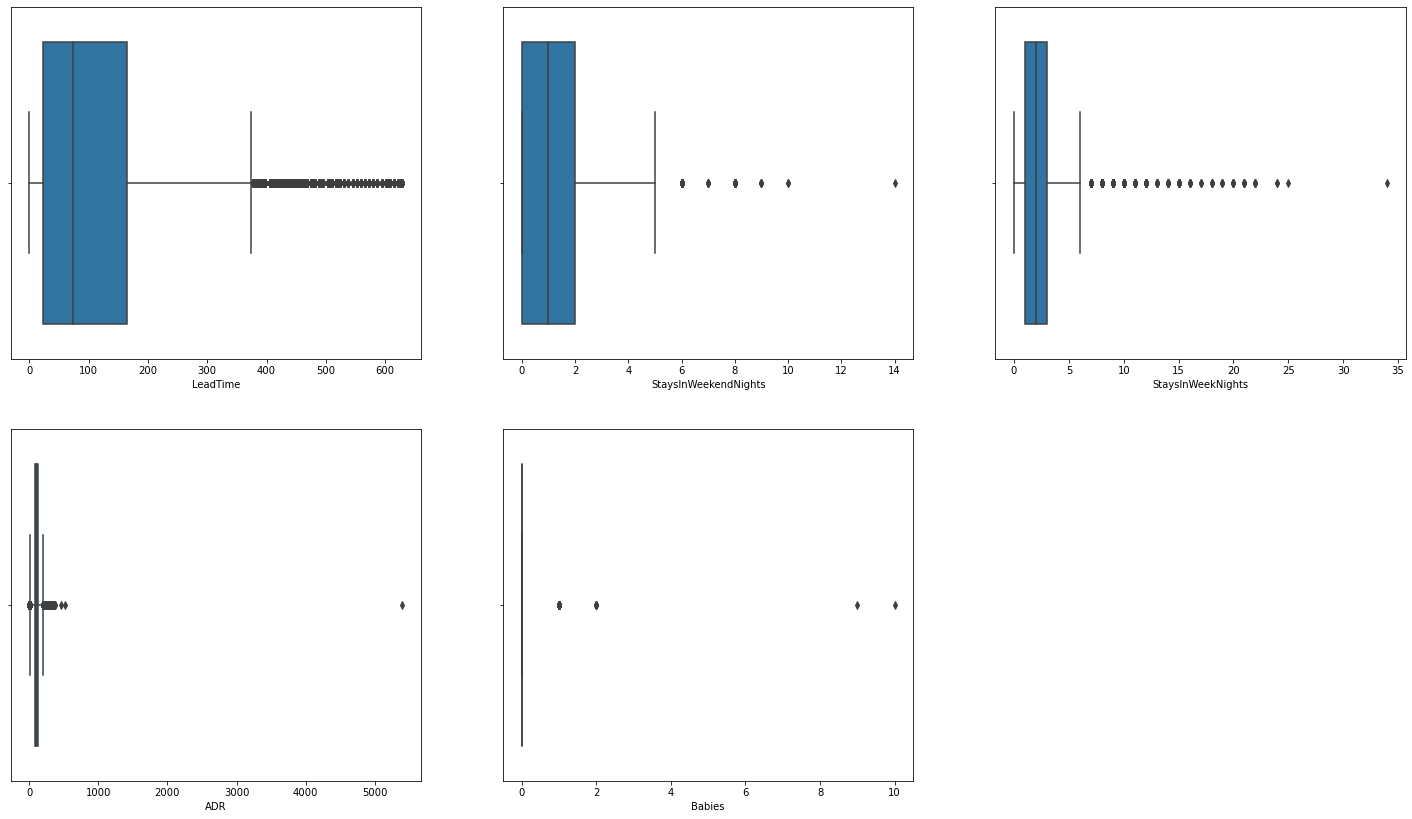

In [5]:
fig, ax = plt.subplots(figsize=(25,22)) 
for i in range(1, 6):
    plt.subplot(3, 3, i) 
    sns.boxplot(x=df[columns[i-1]])

plt.show()

In [6]:
Babies_outl = df[df.Babies > 4].shape[0]  
df.drop(df[df.Babies > 4].index, inplace=True)
df_inp.drop(df_inp[df_inp.Babies > 4].index, inplace=True)

print("We deleted", Babies_outl, "rows")

We deleted 2 rows


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [7]:
#LeadTime
q25 = df["LeadTime"].quantile(0.25)
q75 = df["LeadTime"].quantile(0.75)
iqr = q75 - q25
low = q25 - 3 * iqr
high = q75 + 3 * iqr

series = df["LeadTime"].between(low, high, inclusive=True)
amount = len(df) - series.value_counts()[True]
print(f'Lower point: {round(low, 2)} \t upper point: {round(high, 2)} \t {"LeadTime"} \t {amount}')
    
for index in series[series==False].index.tolist():
    df_inp.loc[index, "LeadTime"] = np.nan

/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Lower point: -400.0 	 upper point: 587.0 	 LeadTime 	 162


In [8]:
#StaysInWeekendNights
q25 = df["StaysInWeekendNights"].quantile(0.25)
q75 = df["StaysInWeekendNights"].quantile(0.75)
iqr = q75 - q25
low = q25 - 2.5 * iqr
high = q75 + 2.5 * iqr

series = df["StaysInWeekendNights"].between(low, high, inclusive=True)
amount = len(df) - series.value_counts()[True]
print(f'Lower point: {round(low, 2)} \t upper point: {round(high, 2)} \t {"StaysInWeekendNights"} \t {amount}')
    
for index in series[series==False].index.tolist():
    df_inp.loc[index, "StaysInWeekendNights"] = np.nan

Lower point: -5.0 	 upper point: 7.0 	 StaysInWeekendNights 	 30


In [9]:
#StaysInWeekNights
q25 = df["StaysInWeekNights"].quantile(0.25)
q75 = df["StaysInWeekNights"].quantile(0.75)
iqr = q75 - q25
low = q25 - 5 * iqr
high = q75 + 5 * iqr

series = df["StaysInWeekNights"].between(low, high, inclusive=True)
amount = len(df) - series.value_counts()[True]
print(f'Lower point: {round(low, 2)} \t upper point: {round(high, 2)} \t {"StaysInWeekNights"} \t {amount}')
    
for index in series[series==False].index.tolist():
    df_inp.loc[index, "StaysInWeekNights"] = np.nan

Lower point: -9.0 	 upper point: 13.0 	 StaysInWeekNights 	 77


In [10]:
#ADR
q25 = df["ADR"].quantile(0.25)
q75 = df["ADR"].quantile(0.75)
iqr = q75 - q25
low = q25 - 6 * iqr
high = q75 + 6 * iqr

series = df["ADR"].between(low, high, inclusive=True)
amount = len(df) - series.value_counts()[True]
print(f'Lower point: {round(low, 2)} \t upper point: {round(high, 2)} \t {"ADR"} \t {amount}')
    
for index in series[series==False].index.tolist():
    df_inp.loc[index, "ADR"] = np.nan

Lower point: -201.6 	 upper point: 406.8 	 ADR 	 3


In [11]:
#sns.boxplot(x=df_inp["TotalOfSpecialRequests"])

In [12]:
null_series = df_inp.isnull().sum()
print(null_series[null_series > 0])

LeadTime                162
StaysInWeekendNights     30
StaysInWeekNights        77
ADR                       3
dtype: int64


KNN inputer

In [13]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
df_inp = imputer.fit_transform(df_inp)

In [14]:
cols = df[columns].columns.tolist()

dic = {}
i = 0

for element in cols:
    dic[i]=element
    i = i + 1
    
df_inp = pd.DataFrame(df_inp).rename(columns=dic)

hier der merge von df_inp zu df wieder

In [15]:
df['LeadTime'] = df_inp['LeadTime']
df['StaysInWeekendNights'] = df_inp['StaysInWeekendNights']
df['StaysInWeekNights'] = df_inp['StaysInWeekNights']
df['ADR'] = df_inp['ADR']

In [16]:
df.dropna(inplace=True)

# Feature Engineering


In [17]:
categoricals = [ 'AssignedRoomType', 'Country', 'CustomerType', 'DepositType', 
                'DistributionChannel', 'IsCanceled', 'IsRepeatedGuest', 'MarketSegment', 'Meal'
                , 'ReservedRoomType', 'ReservationStatus', 'Agent', 'weekend_or_weekday'
                ]#'Agent',  'Company', 'weekend_or_weekday'
                #

We can use one-hot encoding for some non-ordinal features such as country, but due to the numerous categories, this method would incur a higher computational cost. Therefore, the label encoding method will be used instead

In [18]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

for col in categoricals:
    df[col] = labelencoder.fit_transform(df[col])

In [19]:
# Create new DataFrame for categorical data and for numerical data

dfDataCategorical = df[categoricals]
dfDataNumerical= df.drop(df[categoricals], axis = 1)

In [20]:
# Check DataFrame details
dfDataCategorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79155 entries, 0 to 79156
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   AssignedRoomType     79155 non-null  int64
 1   Country              79155 non-null  int64
 2   CustomerType         79155 non-null  int64
 3   DepositType          79155 non-null  int64
 4   DistributionChannel  79155 non-null  int64
 5   IsCanceled           79155 non-null  int64
 6   IsRepeatedGuest      79155 non-null  int64
 7   MarketSegment        79155 non-null  int64
 8   Meal                 79155 non-null  int64
 9   ReservedRoomType     79155 non-null  int64
 10  ReservationStatus    79155 non-null  int64
 11  Agent                79155 non-null  int64
 12  weekend_or_weekday   79155 non-null  int64
dtypes: int64(13)
memory usage: 8.5 MB


Text(0.5, 1.0, 'Correlation Matrix-Spearman Method (Categorical Data)')

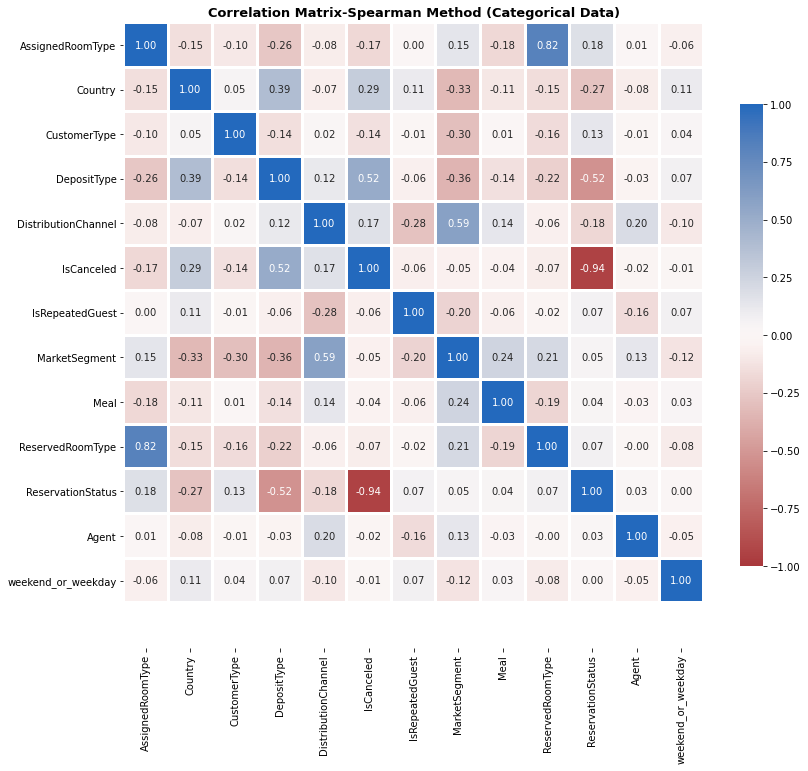

In [21]:
# Correlation matrix with Spearman method
plt.figure(figsize=(13,17))
corrCategorical=dfDataCategorical.corr(method='spearman')
maskCategorical = np.triu(np.ones_like(corrCategorical, dtype=np.bool))
sns.heatmap(corrCategorical, annot=True, fmt=".2f", cmap='vlag_r', vmin=-1, vmax=1, center= 0,
            square=True, linewidths=2, cbar_kws={"shrink": .5}).set(ylim=(14, 0))
plt.title("Correlation Matrix-Spearman Method (Categorical Data)",size=13, weight='bold')

Text(0.5, 1.0, 'Correlation Matrix-Pearson Method (Numerical Data)')

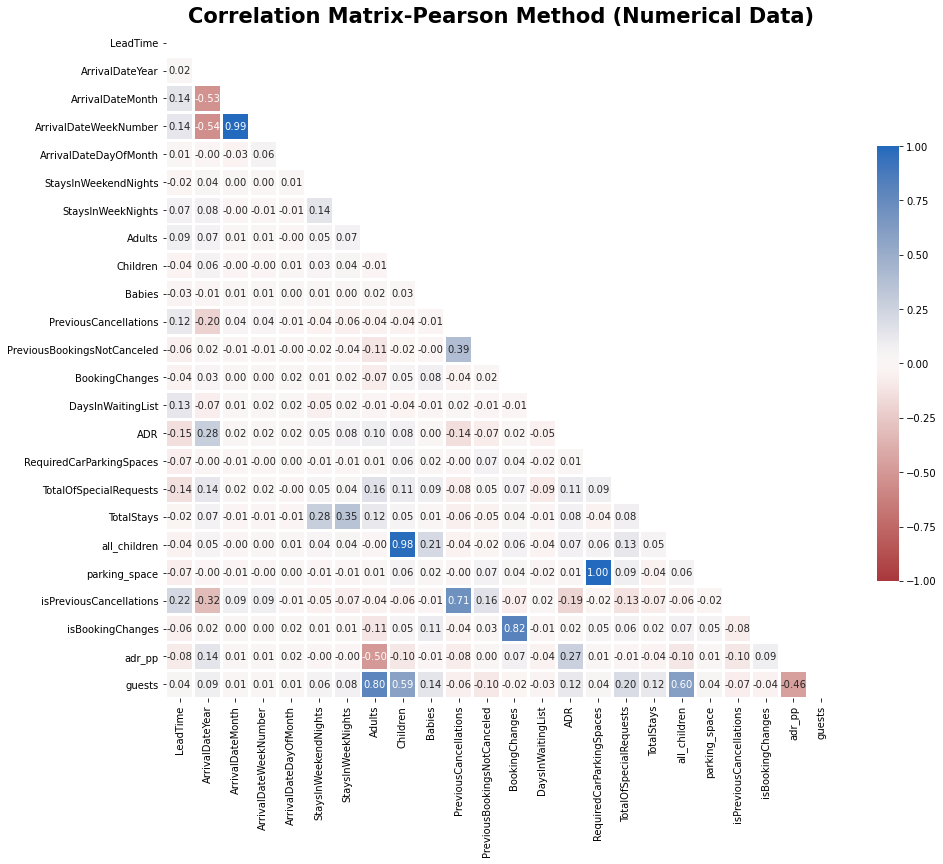

In [22]:
# Correlation matrix with Pearson method
plt.figure(figsize=(15,16))
corrNumerical=dfDataNumerical.corr(method='pearson')
maskNumerical = np.triu(np.ones_like(corrNumerical, dtype=np.bool))
sns.heatmap(corrNumerical, annot=True, fmt=".2f", cmap='vlag_r', mask= maskNumerical, vmin=-1, vmax=1, center= 0,
            square=True, linewidths=2, cbar_kws={"shrink": .5}).set(ylim=(24, 0))
plt.title("Correlation Matrix-Pearson Method (Numerical Data)",size=21, weight='bold')

In [23]:
# Finding highly correlated features
corrMaskCategorical = corrCategorical.mask(maskCategorical)
corrValuesCategorical = [c for c in corrMaskCategorical.columns if any (corrMaskCategorical[c] > 0.80)]
corrMaskNumerical = corrNumerical.mask(maskNumerical)
corrValuesNumerical = [c for c in corrMaskNumerical.columns if any (corrMaskNumerical[c] > 0.80)]
print(corrValuesCategorical, corrValuesNumerical)

['AssignedRoomType'] ['ArrivalDateMonth', 'Children', 'BookingChanges', 'RequiredCarParkingSpaces']


There is also high correlation between cancellation and children & all_children features. Since the all_children feature is comprised of the children and babies features, we can remove children as a feature.

We learned that reservation_ status as a feature has a negative correlation with hotel booking cancellation. 
In this matrix, there appears to be a negative high correlation between reservation_status and is_canceled features. 

Additionally, we will also be removing reservation_status_date from our features since it contains date-type data that cannot be converted into a different type.


In [24]:
corr = df.corr(method = 'spearman')

new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr.correlation > 0.4]
#new_corr[(new_corr.correlation > 0.4) | (new_corr.correlation < 0.4)].head(20)

,level_0,level_1,correlation
1173,parking_space,RequiredCarParkingSpaces,0.999999
1200,isPreviousCancellations,PreviousCancellations,0.999898
1241,isBookingChanges,BookingChanges,0.997998
151,ArrivalDateWeekNumber,ArrivalDateMonth,0.995355
1119,all_children,Children,0.971936
1036,ReservationStatus,IsCanceled,0.940883
1340,guests,Adults,0.890022
721,AssignedRoomType,ReservedRoomType,0.815723
644,PreviousBookingsNotCanceled,IsRepeatedGuest,0.793746
1324,weekend_or_weekday,TotalStays,0.618979


The following diagramm shows the correlation of our dataset. As we can see, we dont have any highly correlated features.

In [25]:
df = df.drop(df[df.ReservationStatus == 2].index)

In [26]:
# Dropping some features from data
df = df.drop(['ReservationStatus', 'ReservationStatusDate', 'Children',
              'BookingChanges', 'RequiredCarParkingSpaces', 'Adults', 'PreviousCancellations',
              'ArrivalDateMonth', 'weekend_or_weekday', 'adr_pp','ArrivalDate', 'DepositType'], axis=1) 
#, 'weekend_or_weekday'

# Model creation

In [27]:
report = pd.DataFrame(columns=['Model','Acc. Train','Acc. Test', 'F1 Score', 'Recall', 'Precicion', 'Time'])
report_auc = pd.DataFrame(columns=['Model','ROC AUC'])

In [28]:
X = df.drop(columns=['IsCanceled']) #, 'Agent', 'Company', 'Country'
y = df['IsCanceled']

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, stratify=y, test_size=0.15)


In [29]:
from sklearn.dummy import DummyClassifier

# Checking baseline model score 
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
print(f'Baseline Training Score: {dummy.score(X_train, y_train)}')
print(f'Baseline Testing Score: {dummy.score(X_test, y_test)}')

Baseline Training Score: 0.588957055214724
Baseline Testing Score: 0.588957055214724


# Feature selection

In [30]:
# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf = XGBClassifier()

rfecv = RFECV(estimator = clf_rf, step = 1, cv = 2, scoring = 'accuracy')   

rfecv.fit(X_train,y_train)

/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:29:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:30:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:31:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:32:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:32:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:32:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:32:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:32:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RFECV(cv=2,
      estimator=XGBClassifier(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, gamma=None, gpu_id=None,
                              importance_type='gain',
                              interaction_constraints=None, learning_rate=None,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              validate_parameters=None, verbosity=None),
      scoring='accuracy')

In [31]:
print('Optimal number of features:', rfecv.n_features_)

features = [f for f,s in zip(X_train.columns, rfecv.support_) if s]
print('The selected features are:')
print ('{}'.format(features))

Optimal number of features: 22
The selected features are:
['LeadTime', 'ArrivalDateYear', 'StaysInWeekendNights', 'StaysInWeekNights', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel', 'IsRepeatedGuest', 'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType', 'Agent', 'DaysInWaitingList', 'CustomerType', 'ADR', 'TotalOfSpecialRequests', 'TotalStays', 'parking_space', 'isPreviousCancellations', 'isBookingChanges', 'guests']


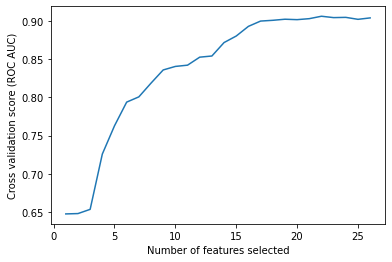

In [32]:
plt.figure()

plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (ROC AUC)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
#plt.savefig('feature_auc_nselected.png', bbox_inches='tight', pad_inches=1)
plt.show()

In [33]:
#Random Forest Built-in Feature Importance
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
#rf.feature_importances_

RandomForestRegressor()

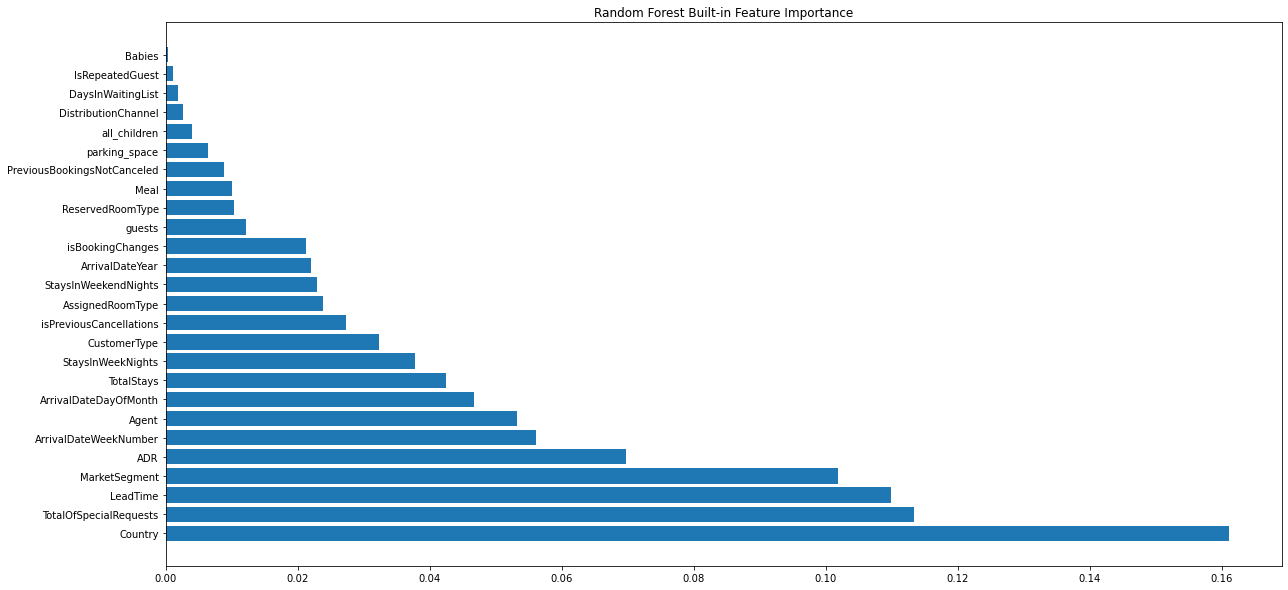

In [34]:
importances = rf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(20,10))
plt.title("Random Forest Built-in Feature Importance")
plt.barh(X.columns[sorted_indices], rf.feature_importances_[sorted_indices])

rfecv_df = pd.DataFrame(rf.feature_importances_,index=X.columns,columns=['Rank']).sort_values(by='Rank',ascending=False)
#rfecv_df.head(10)

In [35]:
#Permutation Based Feature Importance
perm_importance = permutation_importance(rf, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()

Text(0.5, 0, 'Permutation Importance')

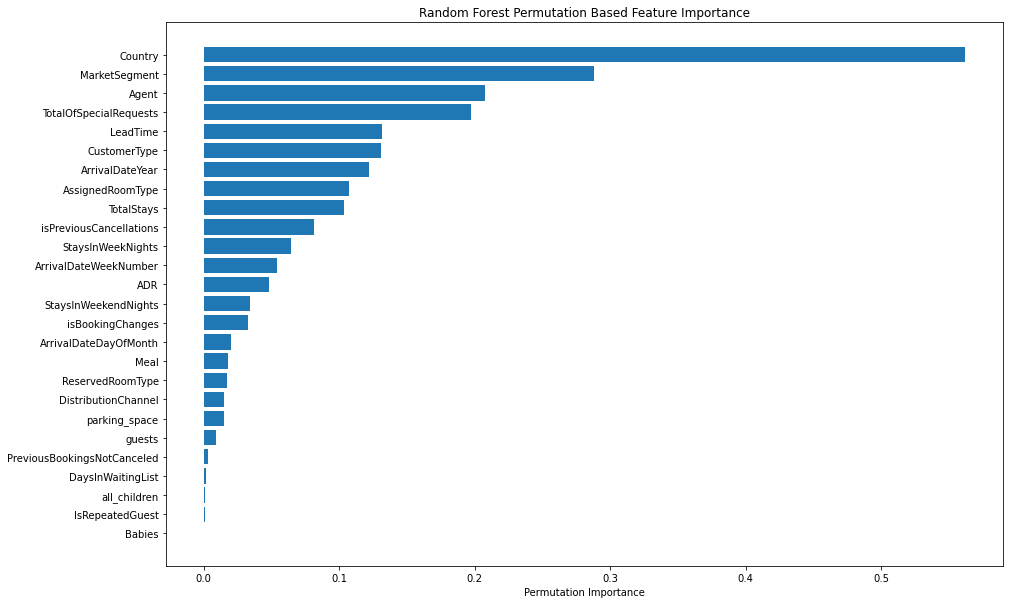

In [36]:
plt.figure(figsize=(15,10))
plt.title("Random Forest Permutation Based Feature Importance")
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [37]:
# Permutation Importance graph with XGB Classifier algorithm
params = {
    'criterion': 'giny', 
    'learning_rate': 0.01, 
    'max_depth': 5,
    'n_estimators': 100, 
    'objective': 'binary:logistic', 
}
model = XGBClassifier(parameters=params)
# fit the model
model.fit(X, y)
# perform permutation importance
result = permutation_importance(model, X, y, scoring='accuracy', n_repeats = 5, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:33:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { parameters } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:33:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


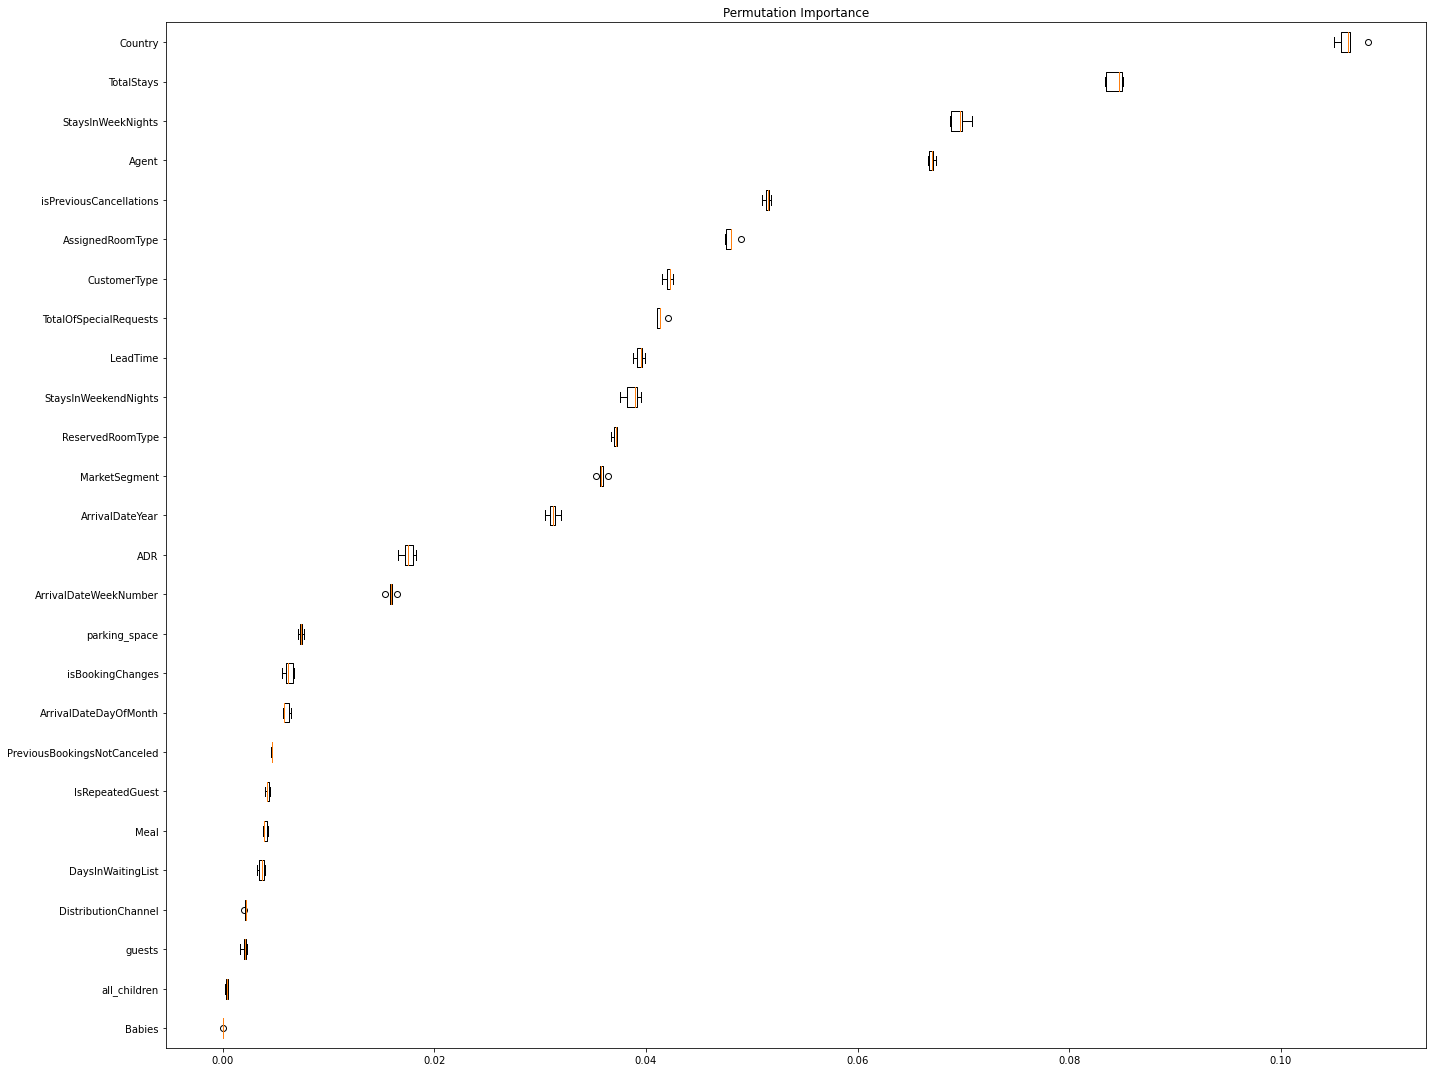

In [38]:
# Permutation Importance Graph 
fig, ax = plt.subplots(figsize=(20,15))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importance")
fig.tight_layout()
plt.show()

It is always good to check all methods, and compare the results. We are using Permutation Importance becasue they are model-agnostic and works well with algorithms not from scikit-learn: Xgboost, LigthGBM.

# Model assessment

In [39]:
# Use standard scaler
from sklearn.preprocessing import StandardScaler
standardScalerX = StandardScaler()
X_train = standardScalerX.fit_transform(X_train)
X_test = standardScalerX.fit_transform(X_test)

In [40]:
# Stratified K-Fold Cross Validation Method
kfold_cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for train_index, test_index in kfold_cv.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [41]:
con_tab = []
def avg_score(model):
    
    start = time.time() 
    model.fit(X_train, y_train)
    end = time.time()

    #Prediction
    train_pred = model.predict(X_train) 
    test_pred = model.predict(X_test)

    f1 = metrics.f1_score(y_test, test_pred, average='micro')
    auc_score = roc_auc_score(y_test, test_pred)
    mse = metrics.mean_squared_error(y_test, test_pred)

    acc_train = accuracy_score(y_train, train_pred)
    acc_test = accuracy_score(y_test, test_pred)
    
    recall_ = recall_score(y_test, test_pred)
    precision_ = precision_score(y_test, test_pred)
    
    conf_test = confusion_matrix(y_test, test_pred)
    con_tab.append(conf_test)
    
    print(model)
    print(conf_test)
    print(classification_report(y_test, test_pred))
    
    report.loc[len(report)] = [model, acc_train, acc_test, f1, recall_, precision_,  (float(end)- float(start))]
    report_auc.loc[len(report_auc)] = [model, auc_score]

In [42]:
models = [LogisticRegression(), 
          #LinearDiscriminantAnalysis(),
          #QuadraticDiscriminantAnalysis(), 
          #GaussianNB(), 
          #SVC(),
          #KNeighborsClassifier(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          GradientBoostingClassifier(), 
          MLPClassifier(), 
          BaggingClassifier(),
          XGBClassifier(),
          lightgbm.LGBMClassifier(),
          ExtraTreesClassifier(),
          AdaBoostClassifier()
         ]

for x in models:
    avg_score(x)

/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()
[[7529 1687]
 [2546 3886]]
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      9216
           1       0.70      0.60      0.65      6432

    accuracy                           0.73     15648
   macro avg       0.72      0.71      0.71     15648
weighted avg       0.73      0.73      0.73     15648

DecisionTreeClassifier()
[[7967 1249]
 [1109 5323]]
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      9216
           1       0.81      0.83      0.82      6432

    accuracy                           0.85     15648
   macro avg       0.84      0.85      0.84     15648
weighted avg       0.85      0.85      0.85     15648

RandomForestClassifier()
[[8663  553]
 [1011 5421]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      9216
           1       0.91      0.84      0.87      6432

    accuracy                  

/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
[[8593  623]
 [ 766 5666]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      9216
           1       0.90      0.88      0.89      6432

    accuracy                           0.91     15648
   macro avg       0.91      0.91      0.91     15648
weighted avg       0.91      0.91      0.91     15648

LGBMClassifier()
[[8566  650]
 [ 987 5445]]
              precis

In [43]:
report.at[0, 'Model'] = 'LogisticRegression()'
report.at[1, 'Model'] = 'DecisionTreeClassifier()'
report.at[2, 'Model'] = 'RandomForestClassifier()'
report.at[3, 'Model'] = 'GradientBoostingClassifier()'
report.at[4, 'Model'] = 'MLPClassifier()'
report.at[5, 'Model'] = 'BaggingClassifier()'
report.at[6, 'Model'] = 'XGBClassifier()'
report.at[7, 'Model'] = 'lightgbm()'
report.at[8, 'Model'] = 'ExtraTreesClassifier()'
report.at[9, 'Model'] = 'AdaBoostClassifier()'

report

,Model,Acc. Train,Acc. Test,F1 Score,Recall,Precicion,Time
0,LogisticRegression(),0.722744,0.729486,0.729486,0.604167,0.697291,0.754741
1,DecisionTreeClassifier(),0.997683,0.849310,0.849310,0.827581,0.809951,0.443295
2,RandomForestClassifier(),0.997683,0.900051,0.900051,0.842817,0.907432,7.380691
3,GradientBoostingClassifier(),0.849549,0.852697,0.852697,0.776897,0.851713,8.351655
4,MLPClassifier(),0.747811,0.742651,0.742651,0.899720,0.631148,12.534866
5,BaggingClassifier(),0.990414,0.885225,0.885225,0.819341,0.892615,2.646802
6,XGBClassifier(),0.928441,0.911235,0.911235,0.880908,0.900938,5.489988
7,lightgbm(),0.898869,0.895386,0.895386,0.846549,0.893355,0.619174
8,ExtraTreesClassifier(),0.997683,0.895450,0.895450,0.833333,0.904794,6.379081
9,AdaBoostClassifier(),0.821718,0.822469,0.822469,0.739739,0.811668,2.210885


Attention:
Most of the Models are overfitting. 
Thererfore the only algorithm that doesn't have an overfitting condition is Logistic Regression, GradientBoostingClassifier, NN and LGBM 
However we will do hyperparameter tuning on all of them to fix the overfitting condition

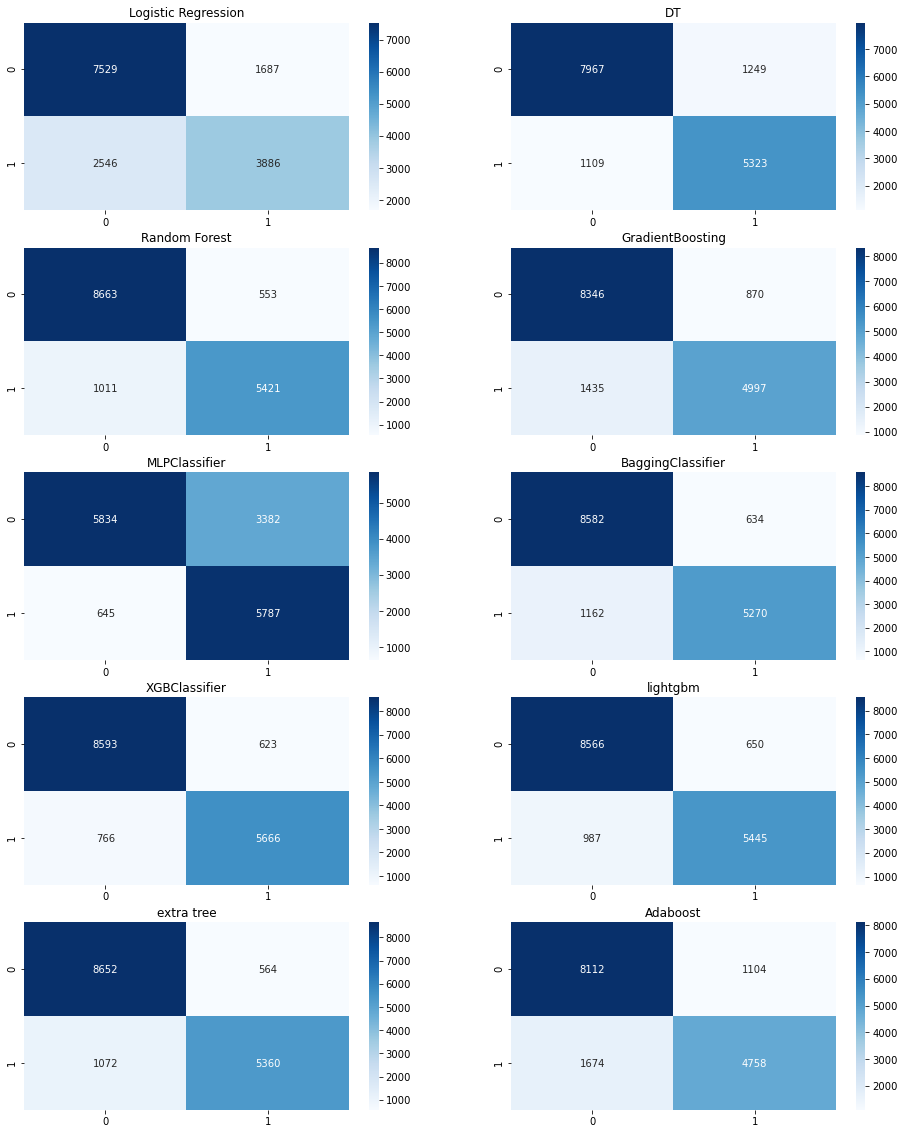

<Figure size 432x288 with 0 Axes>

In [44]:
plt.figure(figsize = (16, 20))

plt.subplot(5,2,1)
sns.heatmap(con_tab[0], annot=True, cmap='Blues', fmt='g')
plt.title("Logistic Regression")

plt.subplot(5,2,2)
sns.heatmap(con_tab[1], annot=True, cmap='Blues', fmt='g')
plt.title('DT')

plt.subplot(5,2,3)
sns.heatmap(con_tab[2], annot=True, cmap='Blues', fmt='g')
plt.title('Random Forest')

plt.subplot(5,2,4)
sns.heatmap(con_tab[3], annot=True, cmap='Blues', fmt='g')
plt.title('GradientBoosting')

plt.subplot(5,2,5)
sns.heatmap(con_tab[4], annot=True, cmap='Blues', fmt='g')
plt.title("MLPClassifier")

plt.subplot(5,2,6)
sns.heatmap(con_tab[5], annot=True, cmap='Blues', fmt='g')
plt.title('BaggingClassifier')

plt.subplot(5,2,7)
sns.heatmap(con_tab[6], annot=True, cmap='Blues', fmt='g')
plt.title('XGBClassifier')

plt.subplot(5,2,8)
sns.heatmap(con_tab[7], annot=True, cmap='Blues', fmt='g')
plt.title('lightgbm')

plt.subplot(5,2,9)
sns.heatmap(con_tab[8], annot=True, cmap='Blues', fmt='g')
plt.title('extra tree')

plt.subplot(5,2,10)
sns.heatmap(con_tab[9], annot=True, cmap='Blues', fmt='g')
plt.title('Adaboost')

plt.show()
#plt.savefig('heatmap.png', transparent=True)

In [45]:
XGB_model = XGBClassifier() # lightgbm.LGBMClassifier
XGB = XGB_model.fit(X_train, y_train)
print(f'Best Training Accuracy: {XGB.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {XGB.score(X_test, y_test)}')

/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:34:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Training Accuracy: 0.9284413343558282
Best Testing Accuracy: 0.9112346625766872


Interpretation: Our model's training score of 92.19 is close to our 91.1% accuracy testing score meaning that we have successfully reduced the variance. 

In [46]:
predict_XGB = XGB.predict(X_test)

# Creating confusion matrix 
cm = confusion_matrix(y_test, predict_XGB)

# putting the matrix a dataframe form  
cm_df = pd.DataFrame(cm, index=['Actually Not Canceled', 'Actually Canceled'],
                 columns=['Predicted Not Canceled', 'Predicted Canceled'])

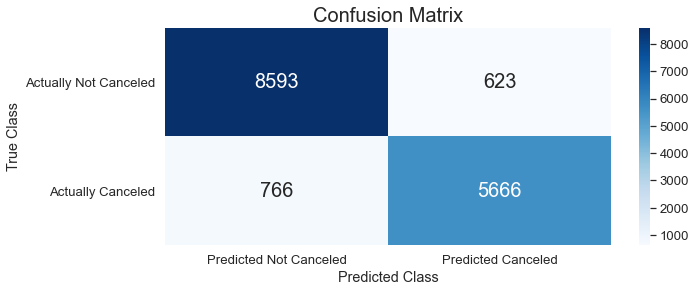

In [47]:
# visualizing the confusion matrix
sns.set(font_scale=1.2)
plt.figure(figsize=(10,4))
    
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues",xticklabels=cm_df.columns, yticklabels=cm_df.index, annot_kws={"size": 20})
plt.title("Confusion Matrix", size=20)
plt.xlabel('Predicted Class')
plt.ylabel('True Class');


In [48]:
# True Positives:
TP = cm[1,1]
# True Negatives:
TN = cm[0,0]
# False Posititives: 
FP = cm[0,1]
# False Negatives: 
FN = cm[1,0]
total = TP+TN+FP+FN

print(f'Correctly classified: {np.round((TP+TN)/total*100)}%')
print(f'Canceled bookings correctly classified: {np.round(TP/(TP+FN)*100)}%')
print(f'Not canceled bookings correctly classified: {np.round(TN/(TN+FP)*100)}%')
print(f'Bookings predicted canceled that are actually canceled: {np.round(TP/(TP+FP)*100)}%')
print(f'Bookings predicted not canceled that are actually not canceled: {np.round(TN/(TN+FN)*100)}%')

Correctly classified: 91.0%
Canceled bookings correctly classified: 88.0%
Not canceled bookings correctly classified: 93.0%
Bookings predicted canceled that are actually canceled: 90.0%
Bookings predicted not canceled that are actually not canceled: 92.0%


# Hyperparameter tuning

In [49]:
# Construct Grid Parameters
lg_params = {
    'penalty': ['l1'], 
    'C': [3.5],
    'max_iter': [500],
    "solver": ["newton-cg", "lbfgs", "liblinear"]
}

# Perform Grid Search
lg_gs = GridSearchCV(LogisticRegression(solver='liblinear', random_state=RANDOM_STATE),
                 lg_params,
                 cv = 5,
                 scoring = 'accuracy')
#lg = lg_gs.fit(X_train, y_train)
avg_score(lg_gs)

report.at[10, 'Model'] = 'LogisticRegression tuned'


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.


/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning

/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning:

One or more of the test scores are non-finite: [       nan        nan 0.71406912]



GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             param_grid={'C': [3.5], 'max_iter': [500], 'penalty': ['l1'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')
[[7890 1326]
 [1983 4449]]
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      9216
           1       0.77      0.69      0.73      6432

    accuracy                           0.79     15648
   macro avg       0.78      0.77      0.78     15648
weighted avg       0.79      0.79      0.79     15648



Text(0.5, 1.0, 'Tuned Model - LogisticRegression')

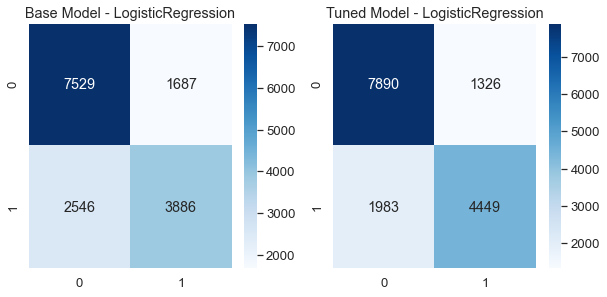

In [50]:
plt.figure(figsize = (10, 4.5))

plt.subplot(1,2,1)
sns.heatmap(con_tab[0], annot = True, cmap='Blues', fmt='g')
plt.title('Base Model - LogisticRegression')

plt.subplot(1,2,2)
sns.heatmap(con_tab[10], annot = True, cmap='Blues', fmt='g')
plt.title('Tuned Model - LogisticRegression')

In [51]:
model = XGBClassifier( subsample=0.8)
avg_score(model)
report.at[11, 'Model'] = 'XGBClassifier tuned'

/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:35:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)
[[8555  661]
 [ 774 5658]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      921

Text(0.5, 1.0, 'XGBClassifier - tuned model')

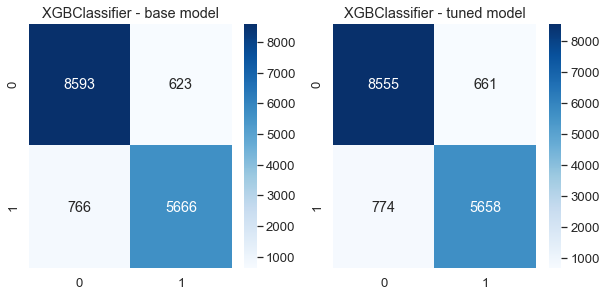

In [52]:
plt.figure(figsize = (10, 4.5))

plt.subplot(1,2,1)
sns.heatmap(con_tab[6], annot=True, cmap='Blues', fmt='g')
plt.title('XGBClassifier - base model')

plt.subplot(1,2,2)
sns.heatmap(con_tab[11], annot=True, cmap='Blues', fmt='g')
plt.title('XGBClassifier - tuned model')

In [53]:
def plot_auc(labels, probs):
    probs = probs[:, 1]
    auc = roc_auc_score(y_test, probs)
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    
    ## Plot the result
    plt.title('ROC AUC score')
    plt.plot(fpr, tpr, color = 'blue', label = 'RF AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.02])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

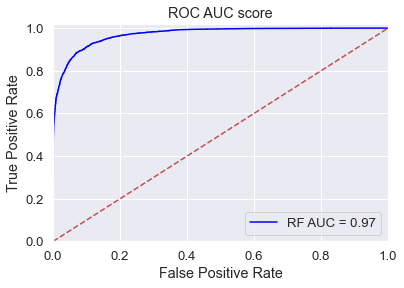

In [54]:
probabilities = XGB.predict_proba(X_test)    
plot_auc(y_test, probabilities)

# Misclassified observations

In [55]:
# Creating a dataframe to compare our predictions to the actual subreddit
analysis = pd.DataFrame(y_test)
analysis['prediction'] = predict_XGB
prediction_analysis = pd.merge(left=analysis, right=X_test, on=analysis.index)

# Looking at the first 5 misclassified posts 
prediction_analysis[prediction_analysis['IsCanceled'] != prediction_analysis['prediction']]

,key_0,IsCanceled,prediction,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Babies,...,DaysInWaitingList,CustomerType,ADR,TotalOfSpecialRequests,TotalStays,all_children,parking_space,isPreviousCancellations,isBookingChanges,guests
5,14,1,0,43.0,2015,27,3,0.0,2.0,0,...,0,3,86.00,0,2,0,0,0,0,2
38,183,0,1,103.0,2015,29,18,2.0,1.0,0,...,0,3,94.50,0,3,0,0,0,0,2
41,210,0,1,12.0,2015,29,18,2.0,2.0,0,...,0,3,62.00,0,4,0,0,0,0,2
44,229,1,0,96.0,2015,30,19,3.0,5.0,0,...,0,2,80.70,0,8,0,0,0,1,1
46,257,0,1,20.0,2015,30,22,0.0,2.0,0,...,0,3,62.00,0,2,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15592,78894,0,1,61.0,2017,35,27,1.0,1.0,0,...,0,2,121.10,0,3,0,0,0,0,2
15617,79016,0,1,131.0,2017,35,27,2.0,3.0,0,...,0,2,89.10,0,5,2,0,0,0,4
15618,79020,0,1,213.0,2017,35,27,1.0,3.0,0,...,0,2,104.00,0,5,2,0,0,0,4
15626,79063,0,1,303.0,2017,35,30,0.0,4.0,0,...,0,2,102.38,1,3,0,0,0,0,2
